## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import qstools.indicators as qsi
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [3]:
from_DB = True
path_to_feather = "..//..//data//feathers//"

xcats = ['NEER_NSA', 'NEER_NSA_P1M1ML12', 'NEER_NSA_P1M3ML1', 'REER_NSA', 'REER_NSA_P1M60ML1']

if from_DB:
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)
    dfd.to_feather(f'{path_to_feather}dfd_ees_qmtl.ftr')   
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_ees_qmtl.ftr')

In [4]:
dfd[['cross_section', 'xcat']] = dfd['ticker'].str.split('_', 1, expand=True)  # split string column
dfd['real_date'] = pd.to_datetime(dfd['real_date'])

In [5]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083920 entries, 0 to 1083919
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   ticker         1083920 non-null  object        
 1   real_date      1083920 non-null  datetime64[ns]
 2   value          1083920 non-null  float64       
 3   grading        1083920 non-null  object        
 4   eop_lag        1083920 non-null  int64         
 5   mop_lag        1083920 non-null  int64         
 6   cross_section  1083920 non-null  object        
 7   xcat           1083920 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 66.2+ MB


In [6]:
cids_exp = sorted(list(set(cids) - set(cids_dmec + ['ARS', 'HKD'])))  # expected cids
xcats_exp = xcats  # expected xcats, in most cases equal to xcats

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['xcat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['xcat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['xcat']==xcat, 'cross_section'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for NEER_NSA:  set()
Missing cids for NEER_NSA_P1M1ML12:  set()
Missing cids for NEER_NSA_P1M3ML1:  set()
Missing cids for REER_NSA:  set()
Missing cids for REER_NSA_P1M60ML1:  set()


## Functions

In [7]:
def check_availability(df, xcats, cids=None, size=None):
    """Display starting years across extended categories and cross sections"""
    
    dfx = df[df['xcat'].isin(xcats)]
        
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    df_rstarts = dfx[['cross_section', 'xcat', 'real_date']].groupby(['cross_section', 'xcat']).min()
    df_rstarts['real_date']=pd.DatetimeIndex(df_rstarts.loc[:,'real_date']).year
    df_rstarts = df_rstarts.unstack().loc[:,'real_date']
    
    if size is None:
        size = (max(len(cids)/2, 15), max(1, len(xcats)/3))
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(df_rstarts.T, cmap='Reds', center=2002, annot=True, fmt='.0f', linewidth=1, cbar=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [8]:
def bars_sds(df, xcats, start_year=2000, cids=None, val=None, title=None, ylab=None):
    """Plot level bars and SD ranges across extended categories and cross sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = dfd[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    sns.set(style="whitegrid")
    
    if val is None:
        val = 'value'
    if title is None:
        title = f'Means and standard deviations since {start_year}'
    if ylab is None:
        ylab=""

    g = sns.catplot(
        data=dfx, kind="bar", height=6, aspect=2.5,
        x="cross_section", y=val, hue="xcat",
        ci="sd", palette="Paired", alpha=.6, order = cids
    )
    g.despine(left=True)
    g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
    g.fig.suptitle(title, y = 1.03, fontsize=14)
    g.set_axis_labels("", ylab)
    plt.show()

In [9]:
def timeline_grid(df, xcats, start_year=2000, cids=None, val='value', ncol=3, same_y=False):
    """Plot grid of timelines of one or more extended categories across sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = df[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]    

    sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
    fg = sns.FacetGrid(dfx, col='cross_section', col_wrap = ncol, sharey=same_y, aspect = 1.7, col_order = cids)
    fg.map_dataframe(sns.lineplot, x='real_date', y=val, hue='xcat', ci=None)
    fg.map(plt.axhline, y=0, c=".5")
    fg.set_titles(col_template='{col_name}')
    fg.add_legend()
    plt.show()

In [10]:
def map_xcorrel(df, xcat, cids, start):
    
    df = df[df['xcat']==xcat]

    cids_in_df = df['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        df = df[df['cross_section'].isin(cids)]

    df_w = df.pivot(index='real_date', columns='cross_section', values='value')

    sns.set(style="ticks")  
    corr = df_w.corr()  # compute correlation matrix
    mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
    f, ax = plt.subplots(figsize=(14, 8))  # set up figure
    sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                square=False, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set(xlabel='', ylabel='')
    ax.set_title(f'Cross crorrelation of {xcat} since {start}',fontsize=14)
    plt.show()

## Availability

Missing cross sections:  set()


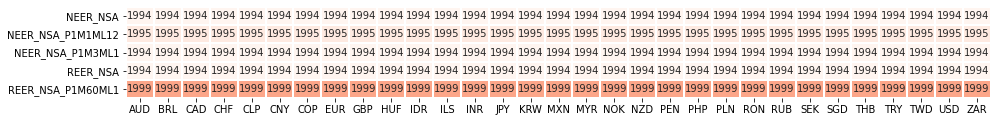

In [11]:
check_availability(dfd, xcats=xcats, cids=cids_exp)

## Distribution and timelines

### JPM indices

Missing cross sections:  set()


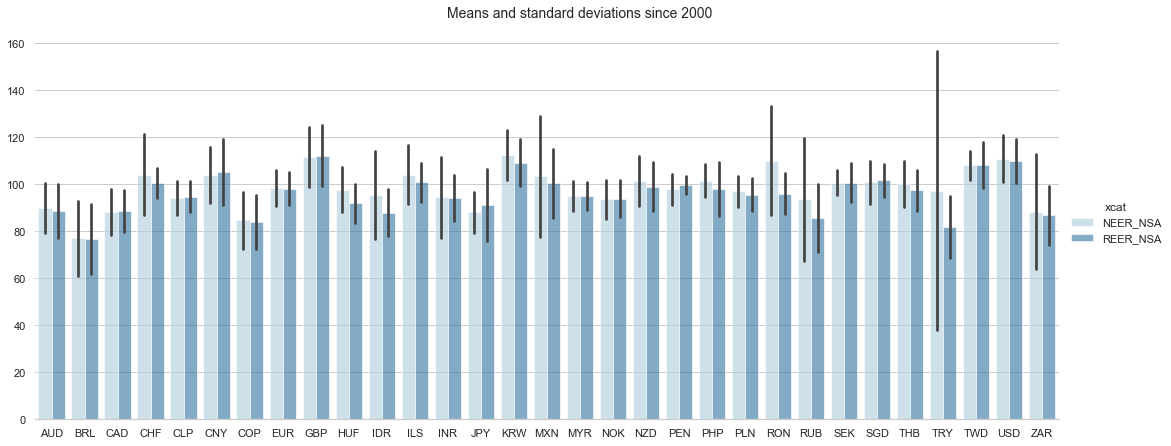

In [12]:
bars_sds(dfd, xcats=['NEER_NSA', 'REER_NSA'], start_year=2000, cids=cids_exp)

Missing cross sections:  {'FRF', 'ESP', 'DEM', 'ITL', 'NLG'}


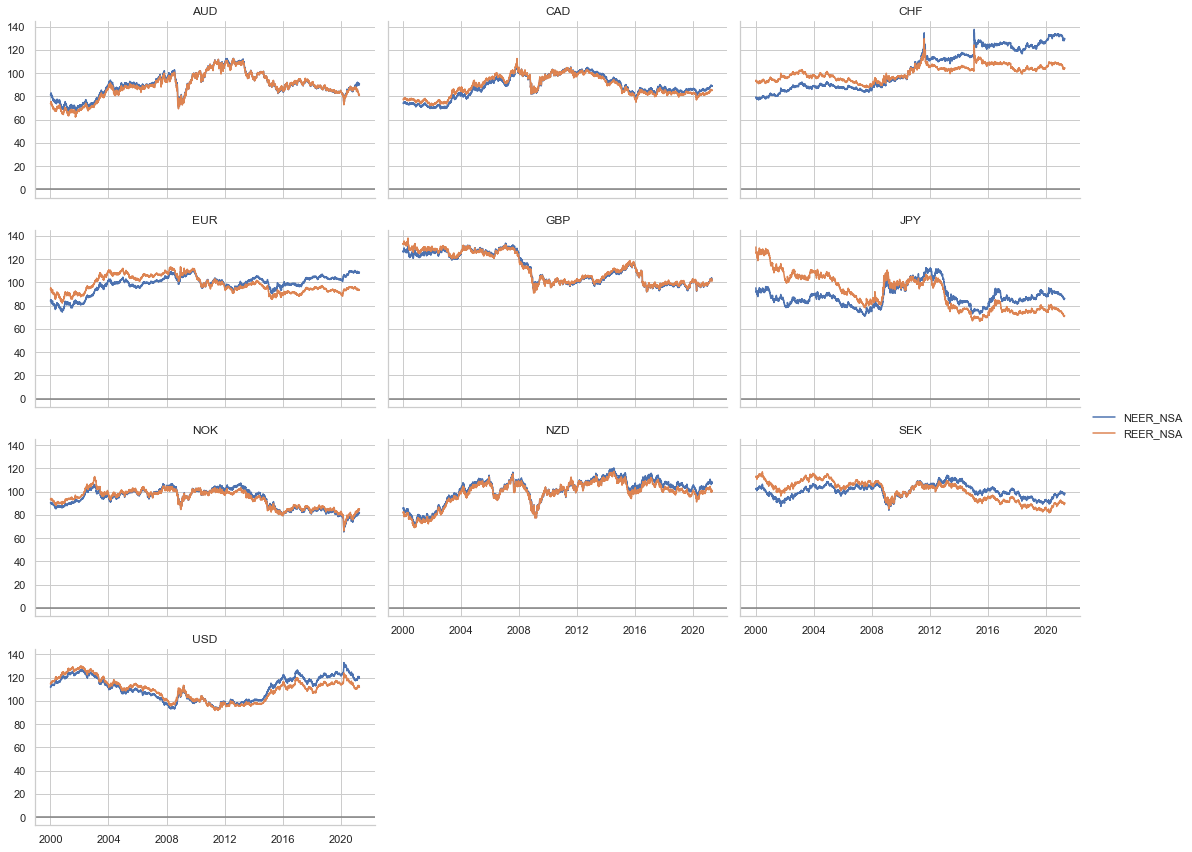

In [13]:
timeline_grid(dfd, xcats=['NEER_NSA', 'REER_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'HKD'}


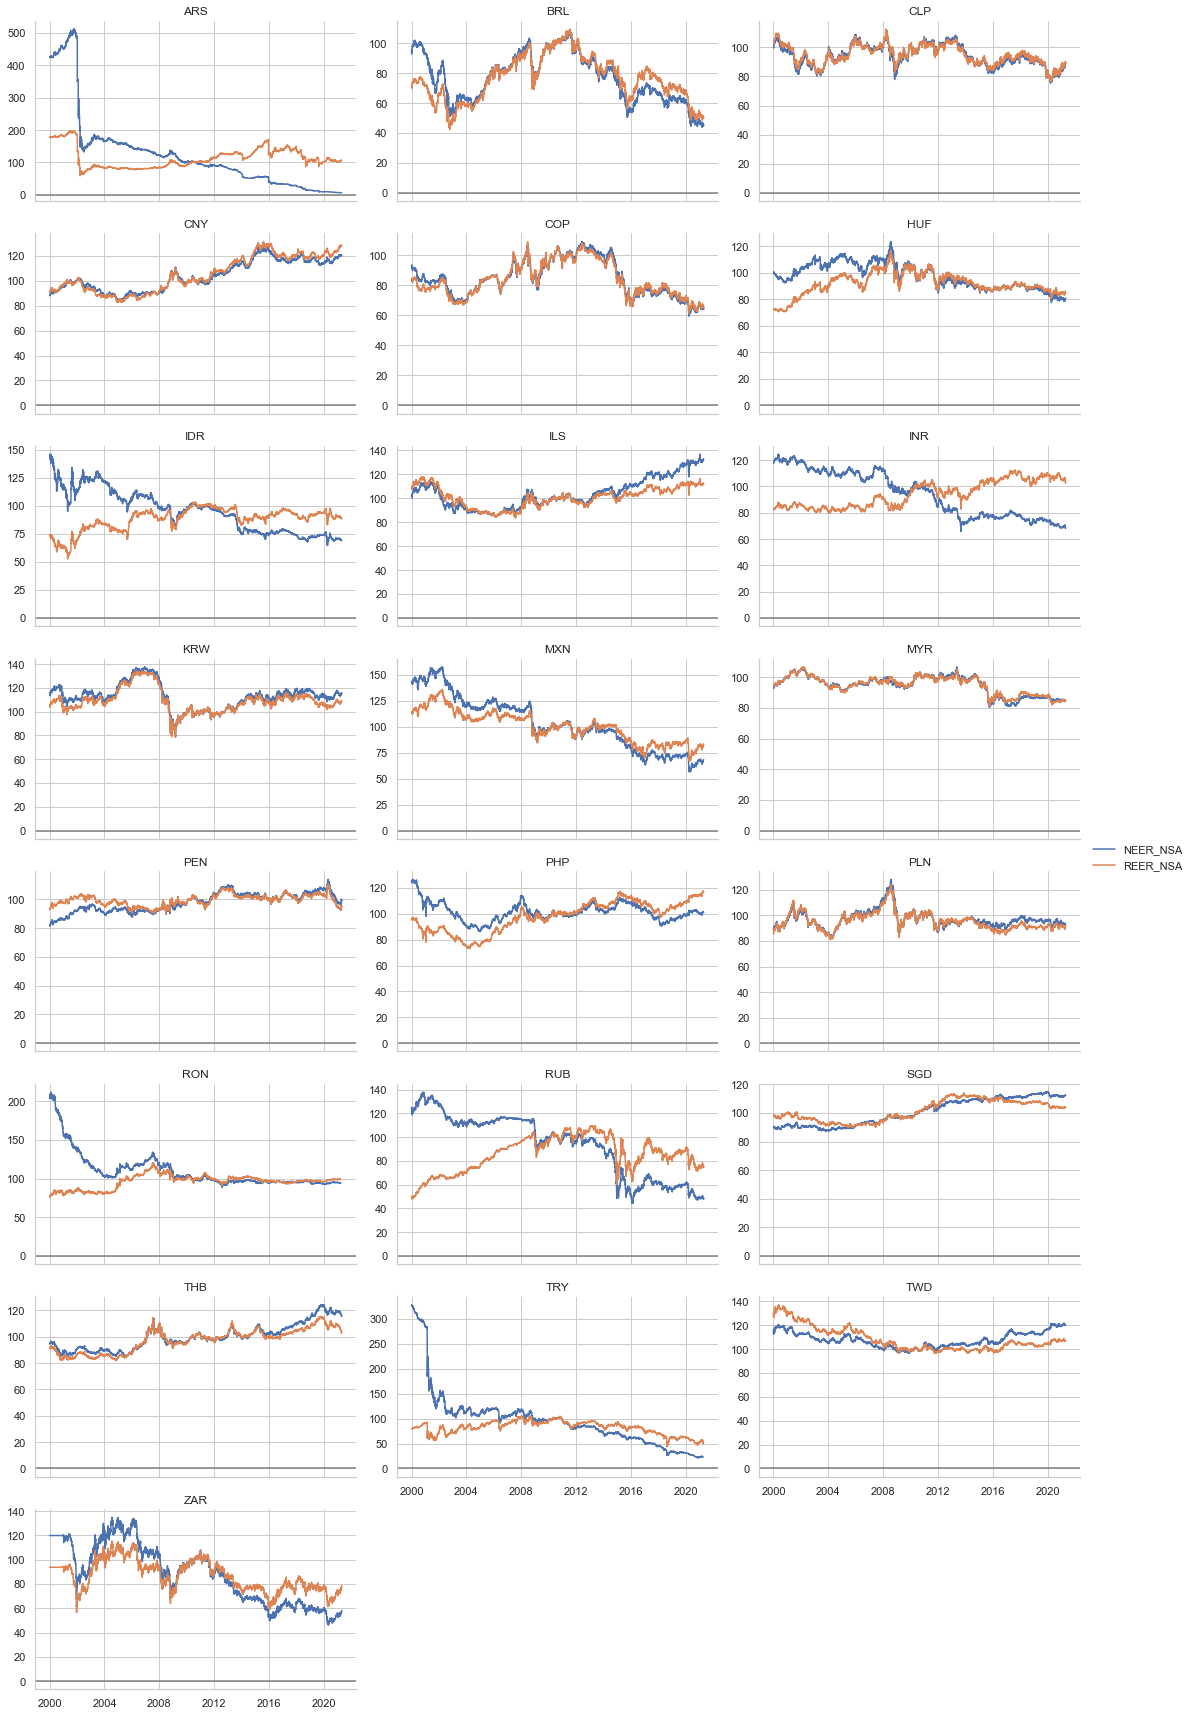

In [14]:
timeline_grid(dfd, xcats=['NEER_NSA', 'REER_NSA'], cids=cids_em, same_y=False)

### Nominal effectiv appreciation (incorrect)

Missing cross sections:  set()


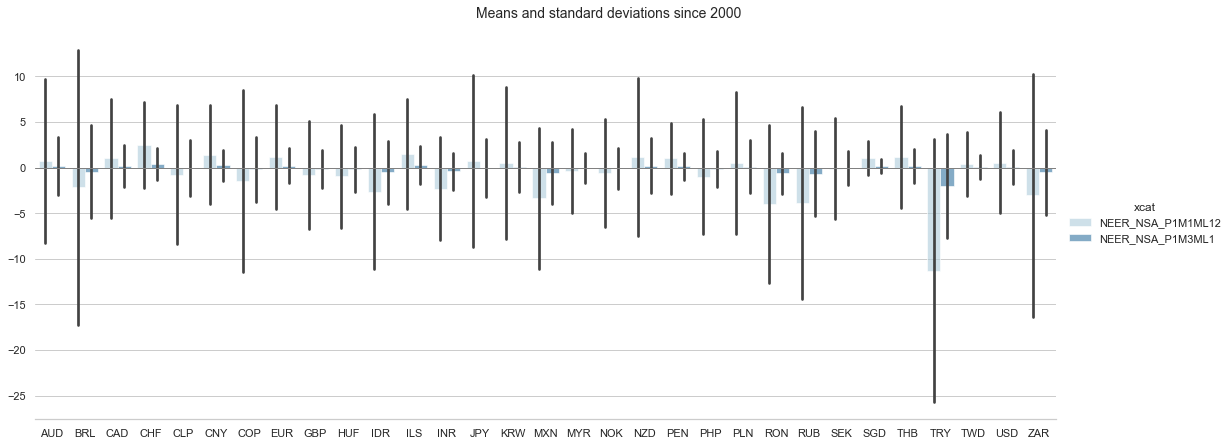

In [15]:
bars_sds(dfd, xcats=['NEER_NSA_P1M3ML1', 'NEER_NSA_P1M1ML12'], start_year=2000, cids=cids_exp)

Missing cross sections:  {'FRF', 'ESP', 'DEM', 'ITL', 'NLG'}


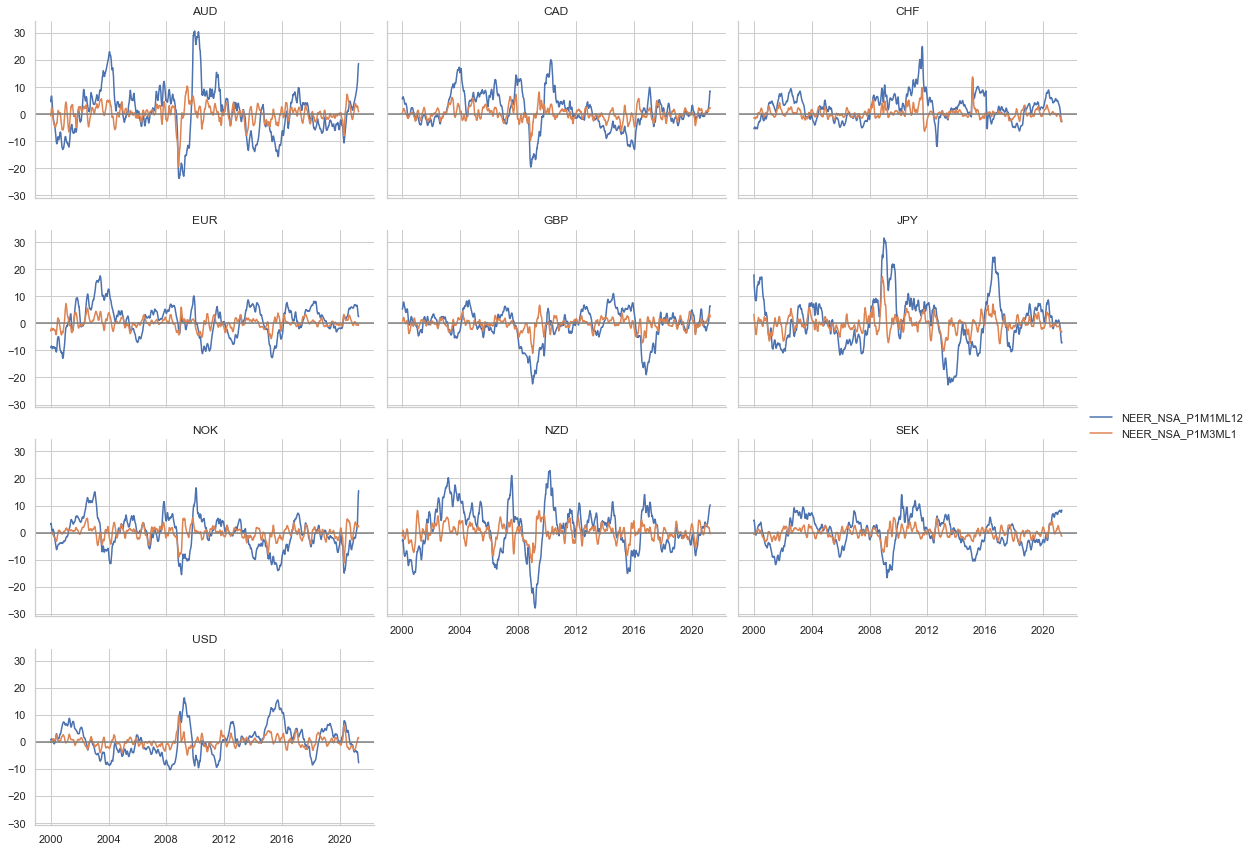

In [16]:
timeline_grid(dfd, xcats=['NEER_NSA_P1M3ML1', 'NEER_NSA_P1M1ML12'], cids=cids_dm, same_y=True)

Missing cross sections:  {'HKD'}


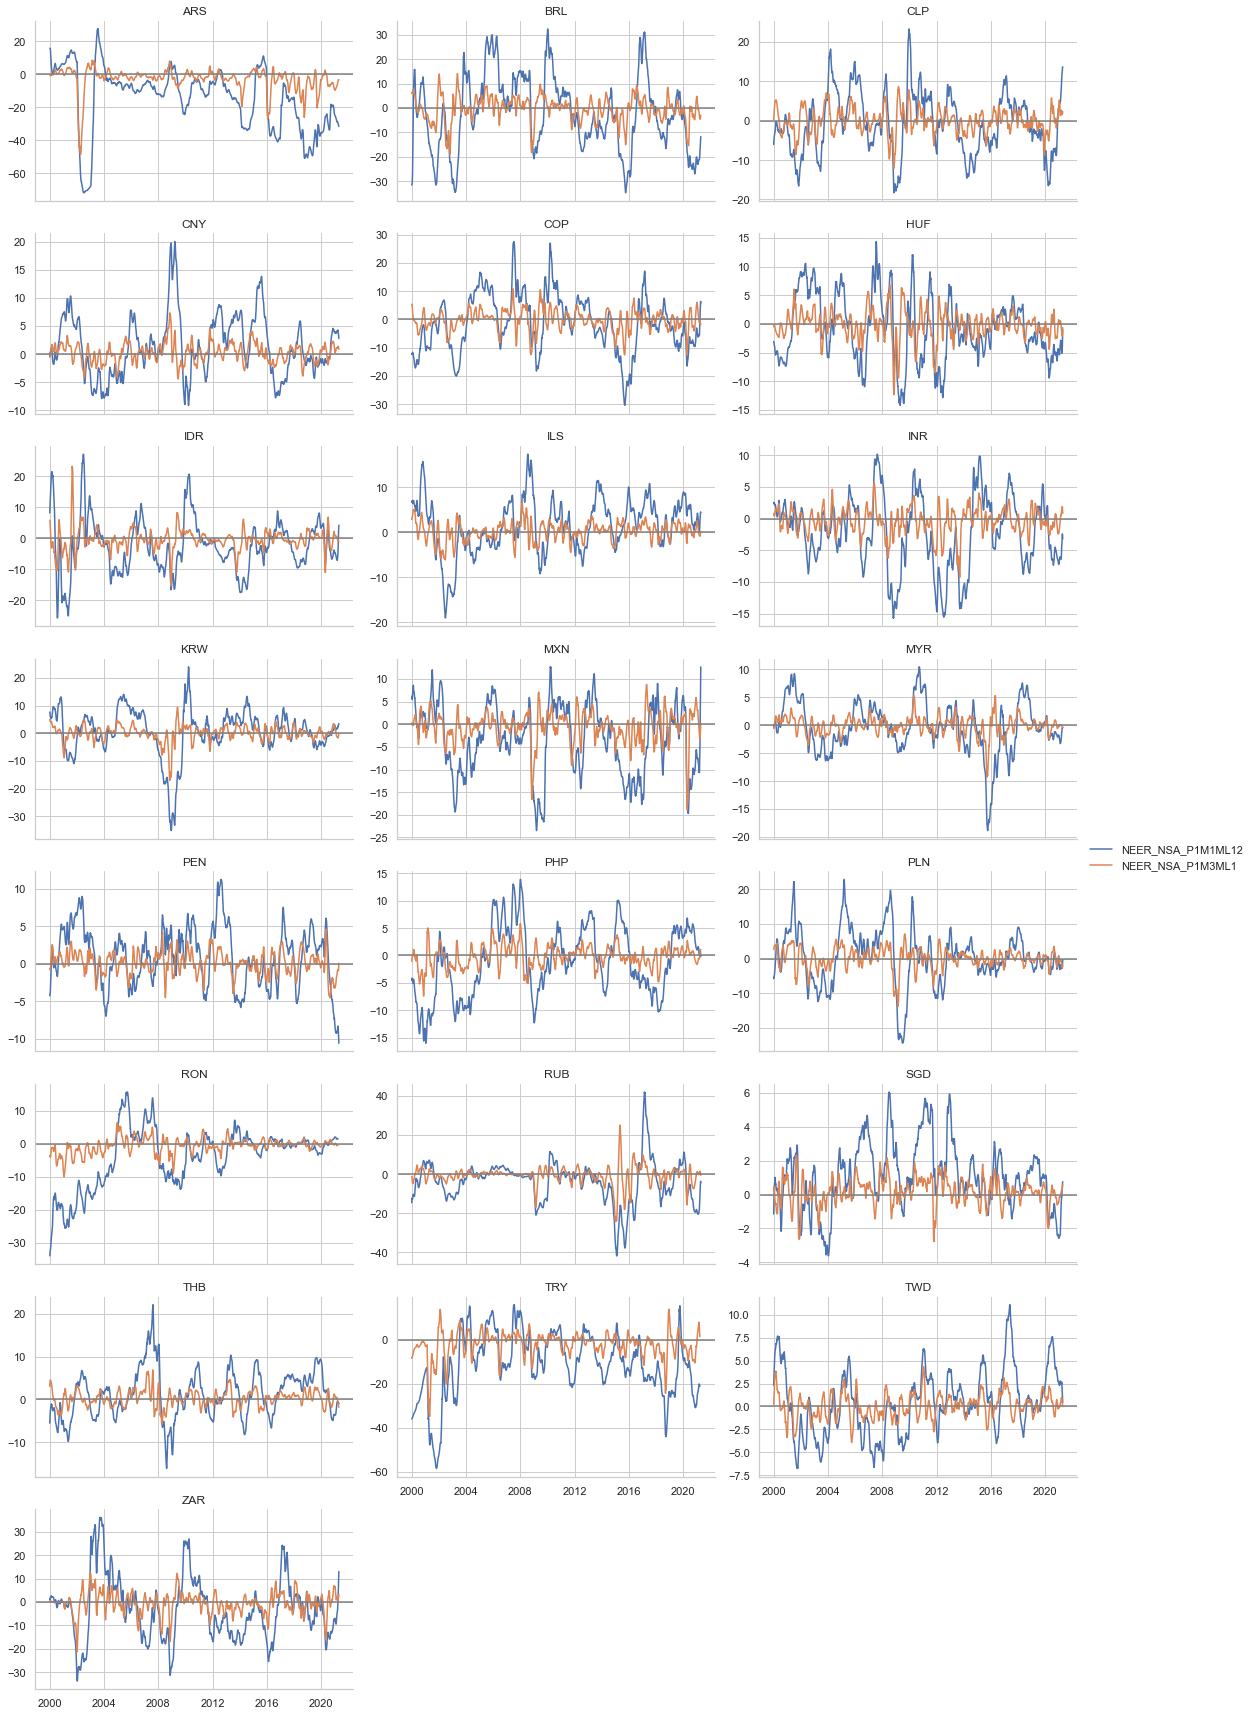

In [17]:
timeline_grid(dfd, xcats=['NEER_NSA_P1M3ML1', 'NEER_NSA_P1M1ML12'], cids=cids_em, same_y=False)

### Real effective exchange rate strength

Missing cross sections:  set()


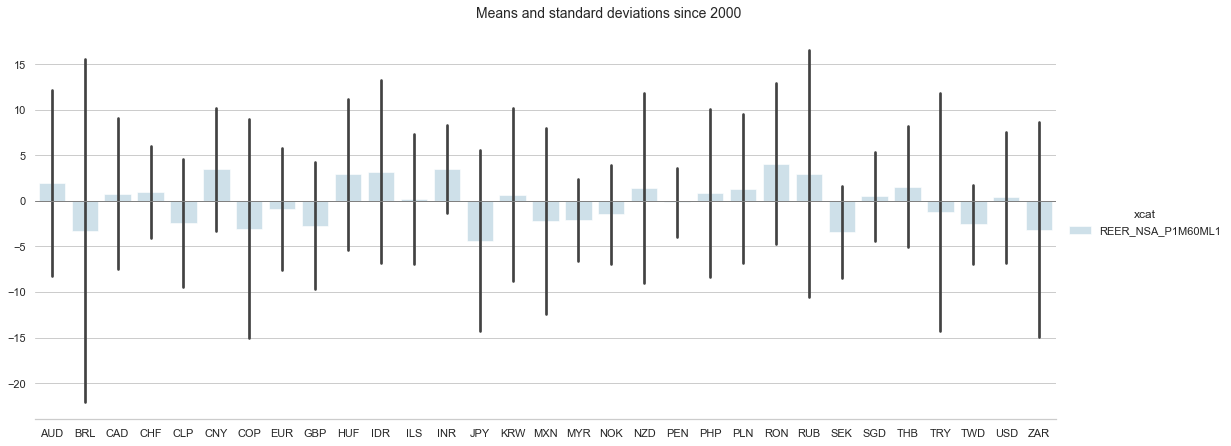

In [18]:
bars_sds(dfd, xcats=['REER_NSA_P1M60ML1'], start_year=2000, cids=cids_exp)

Missing cross sections:  {'FRF', 'ESP', 'DEM', 'ITL', 'NLG'}


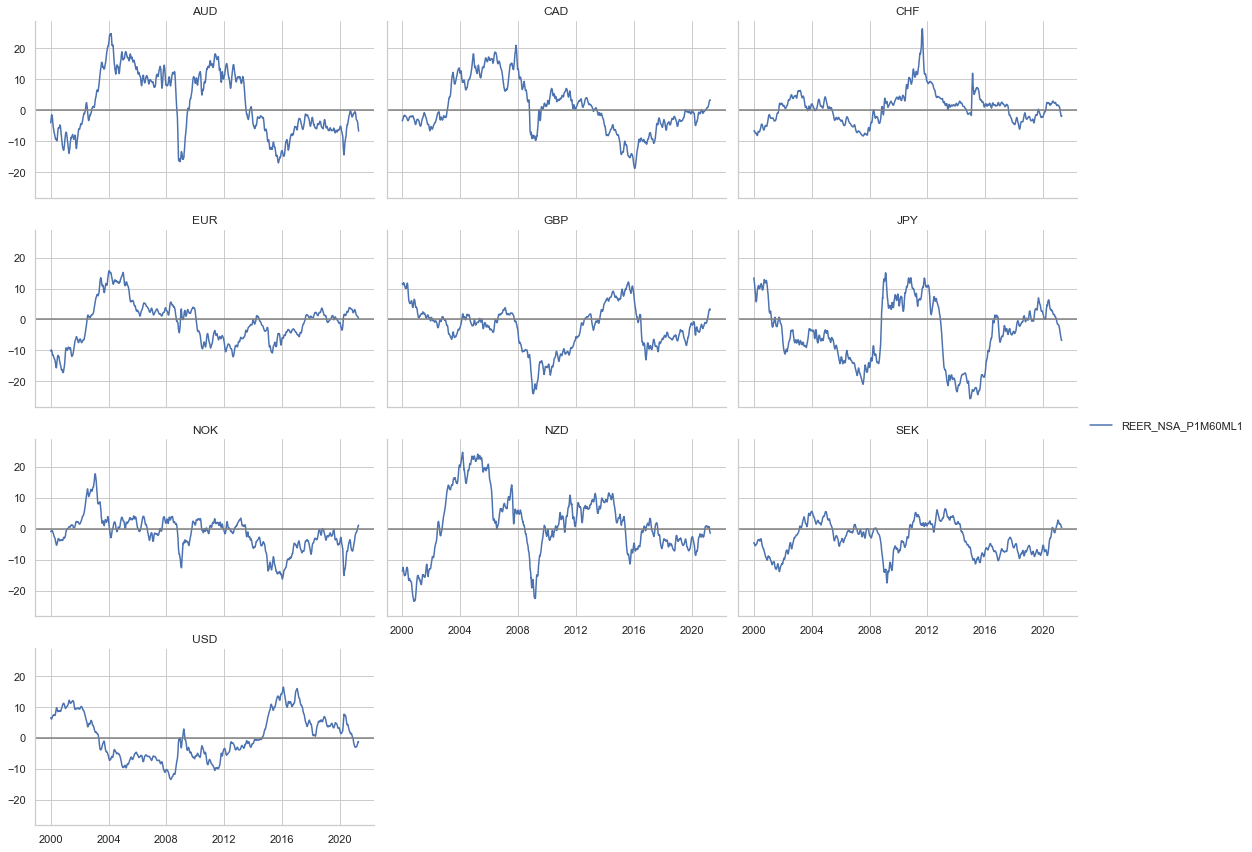

In [19]:
timeline_grid(dfd, xcats=['REER_NSA_P1M60ML1'], cids=cids_dm, same_y=True)

Missing cross sections:  {'HKD'}


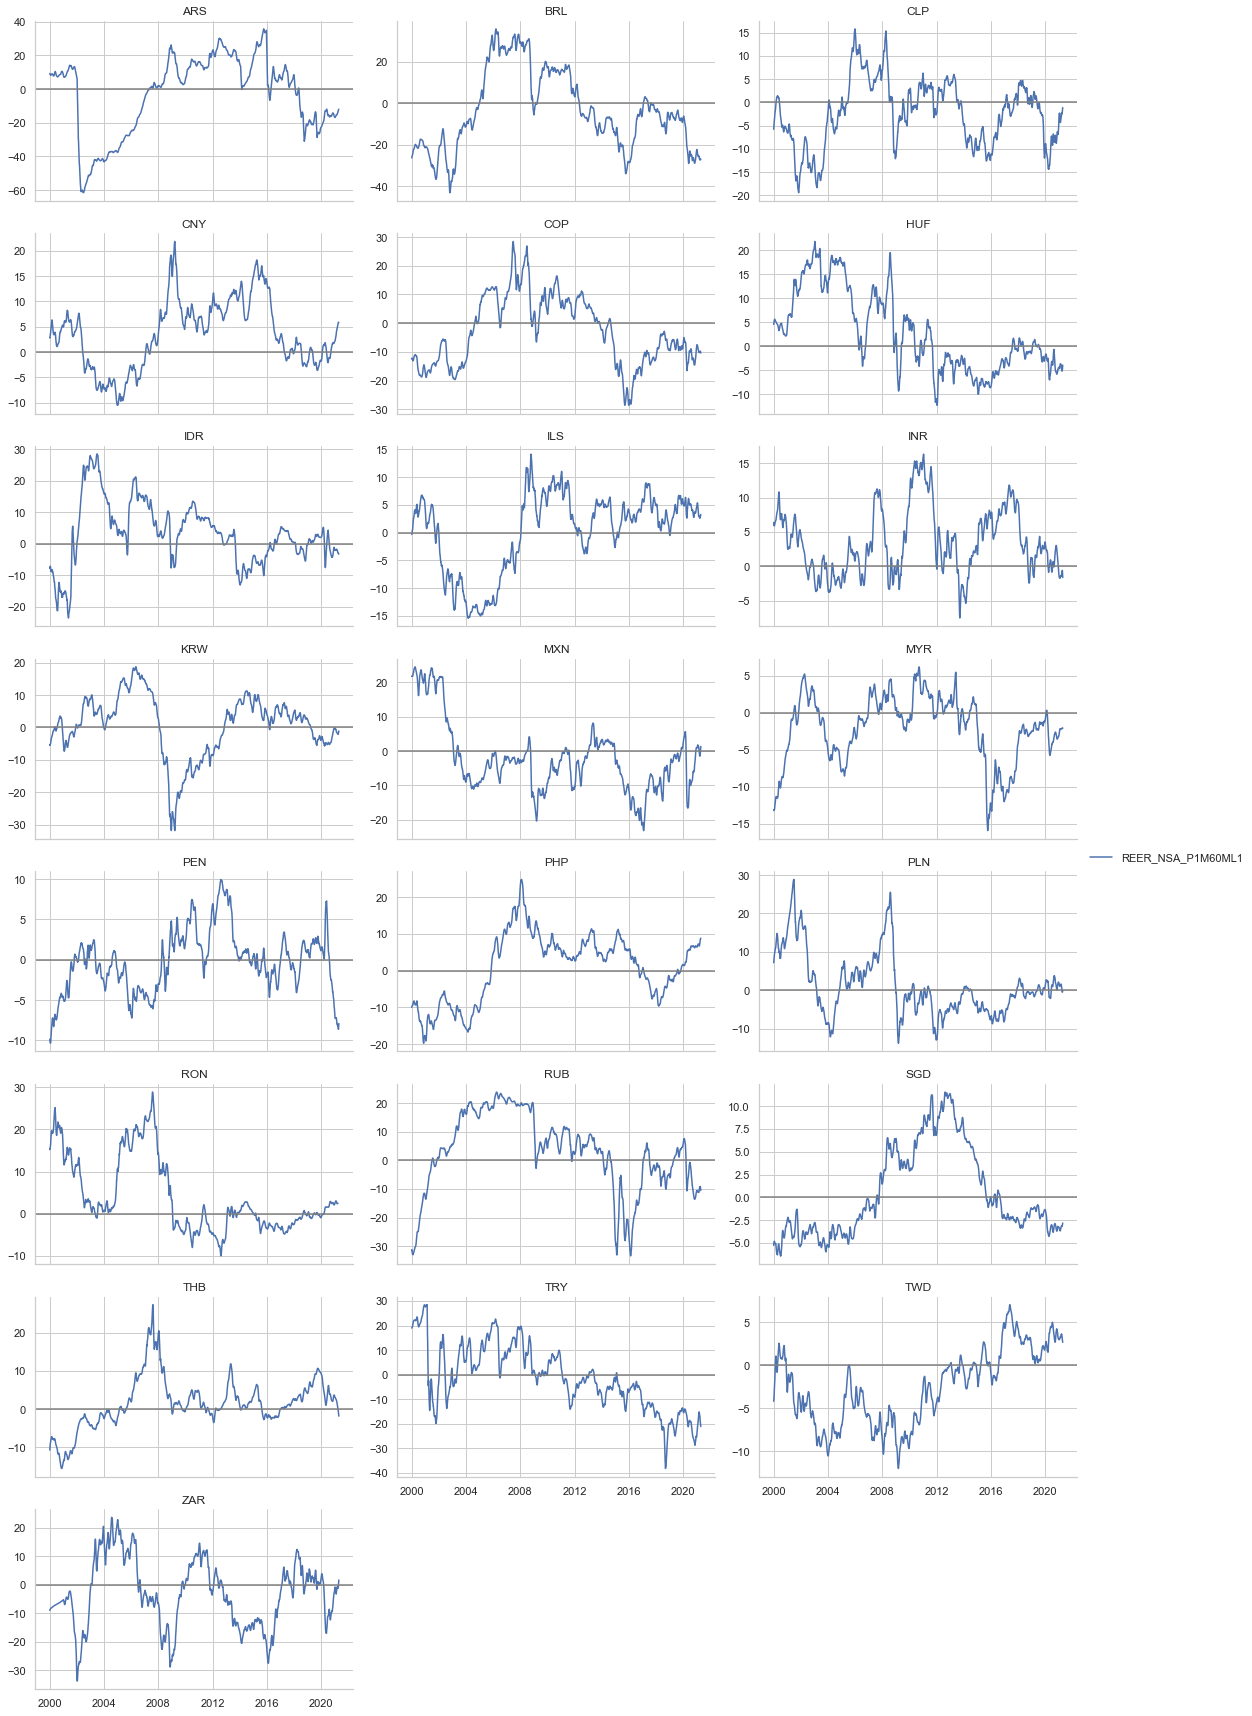

In [20]:
timeline_grid(dfd, xcats=['REER_NSA_P1M60ML1'], cids=cids_em, same_y=False)

## Plausibility

Missing cross sections:  set()


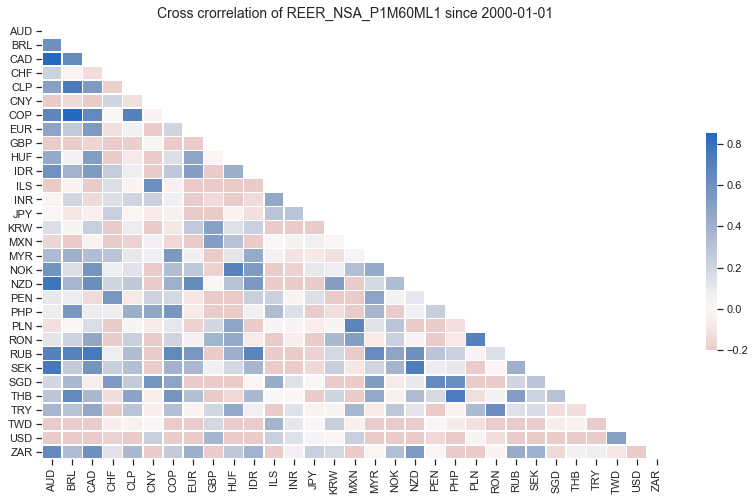

In [21]:
map_xcorrel(dfd, xcat='REER_NSA_P1M60ML1', cids=cids_exp, start="2000-01-01")